# Aug 9th, 2022 (Perm: OCs / overall)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 15
fig_dir = 'Fig2_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig2_OCs

In [3]:
num_k = 7
save_dir = pjoin(fig_dir, f"K{num_k}")
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig2_OCs/K7

## Prepare (512)

In [4]:
mice = Mice(nn)

### Results

In [5]:
%%time

results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    merge_thres=0.444,
    n_resamples=int(1e4),
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 5min 22s, sys: 18.7 s, total: 5min 41s
Wall time: 5min 41s


[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'sim',
    'sim_overall',
    'sim_b',
    'sim_overall_b',
    'good_runs',
    'sim_run',
    'sim_run_overall',
    'tests',
    'tests_overall'
]

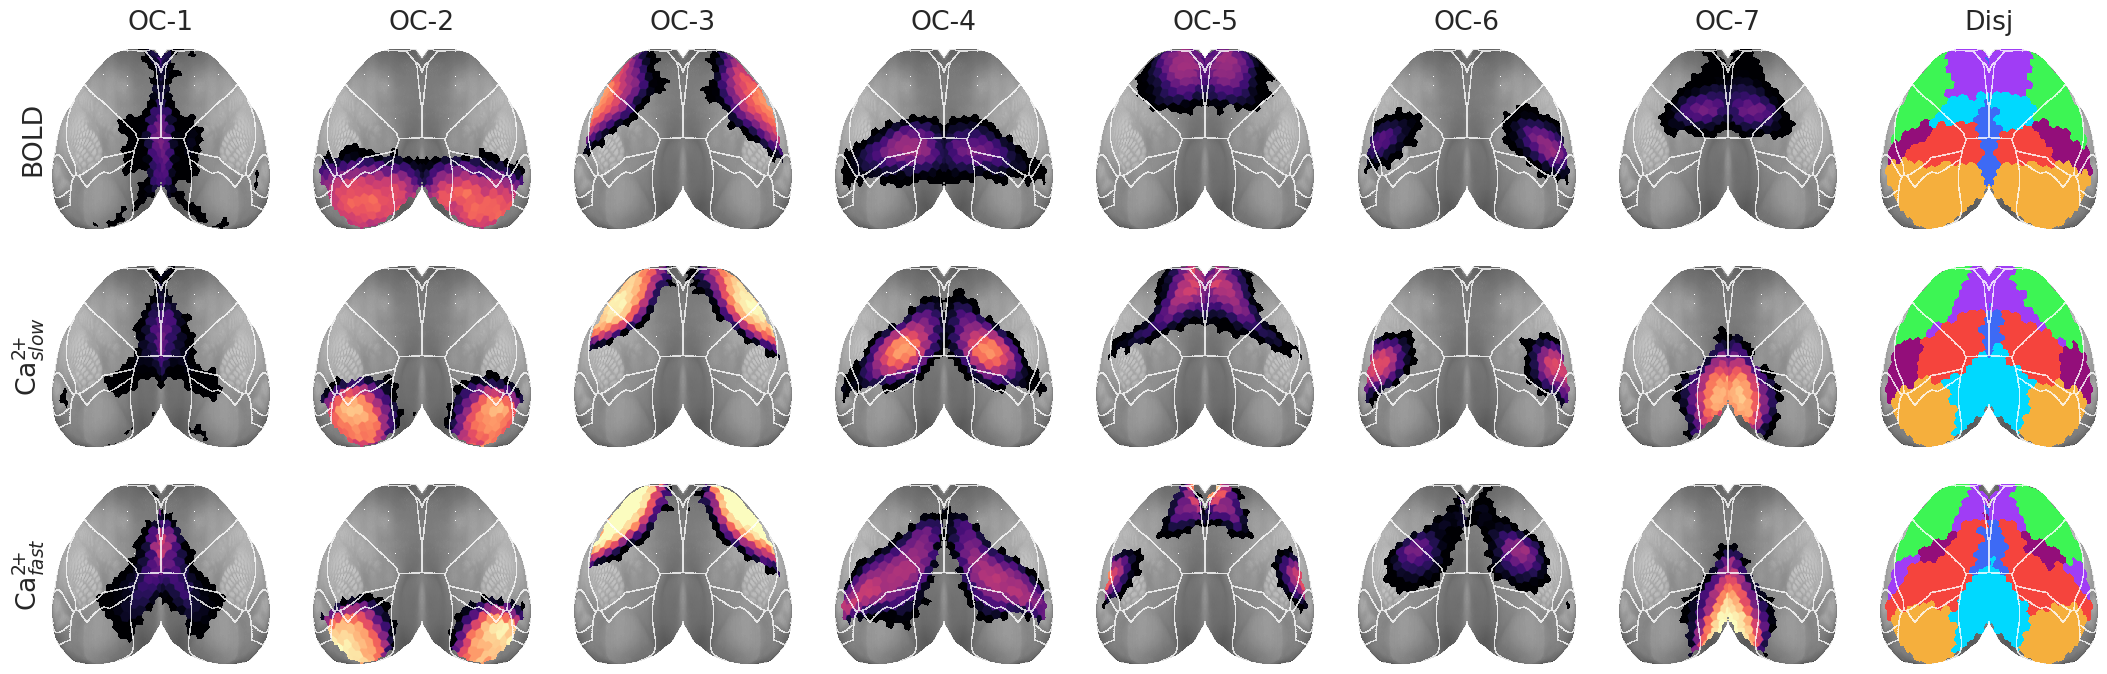

In [6]:
_ = bt.show(results['pi_sorted'], **show_kws(num_k))

### tests

#### Overall

In [7]:
test = list(results['tests_overall'].values())[0]

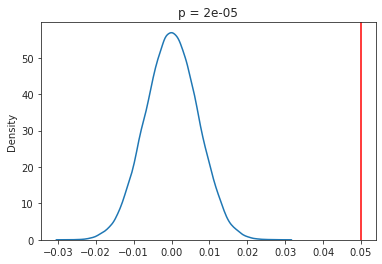

In [8]:
sns.kdeplot(test.null_distribution)
plt.axvline(test.statistic, color='r')
plt.title(f"p = {test.pvalue:1.2g}");

#### Diagonal terms

In [9]:
test = list(results['tests'].values())[0]

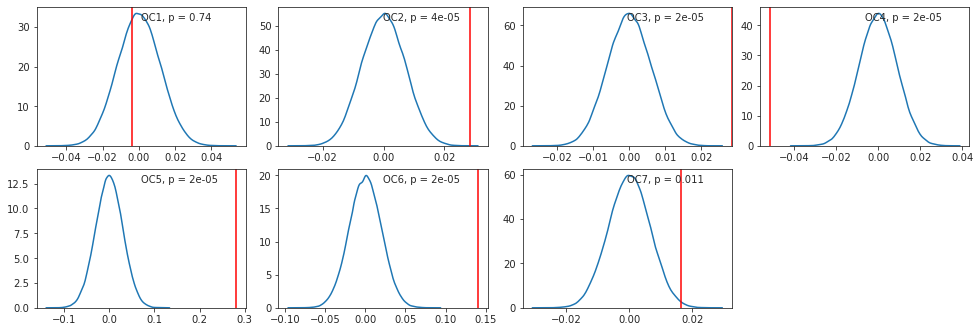

In [10]:
fig, axes = create_figure(2, 4, (13.5, 4.5), constrained_layout=True)
for i, p in enumerate(test.pvalue):
    ax = axes.flat[i]
    sns.kdeplot(test.null_distribution[:, i], ax=ax)
    ax.axvline(test.statistic[i], color='r')
    ax.annotate(
        text=f"OC{i+1}, p = {p:1.2g}",
        xycoords='axes fraction',
        xy=(0.5, 0.9),
        fontsize=10,
    )
    ax.set_ylabel('')
trim_axs(axes, len(test.pvalue))
plt.show()

In [11]:
multipletests(test.pvalue, method='holm')

(
    array([False,  True,  True,  True,  True,  True,  True]),
    array([7.41852581e-01, 1.39998600e-04, 1.39998600e-04, 1.39998600e-04,
       1.39998600e-04, 1.39998600e-04, 2.25597744e-02]),
    0.007300831979014655,
    0.0071428571428571435
)

In [12]:
multipletests(test.pvalue, method='bonferroni')

(
    array([False,  True,  True,  True,  True,  True, False]),
    array([1.00000000e+00, 2.79997200e-04, 1.39998600e-04, 1.39998600e-04,
       1.39998600e-04, 1.39998600e-04, 7.89592104e-02]),
    0.007300831979014655,
    0.0071428571428571435
)

### Do more perms

In [66]:
%%time

output = sim_perm(results['bt_dict'], int(1e6))

CPU times: user 35min 36s, sys: 393 ms, total: 35min 36s
Wall time: 35min 36s


In [67]:
%%time

output = sim_perm(results['bt_dict'], int(1e7))

CPU times: user 6h 2min 18s, sys: 7.47 s, total: 6h 2min 25s
Wall time: 6h 2min 26s


In [69]:
test = list(output['tests'].values())[0]

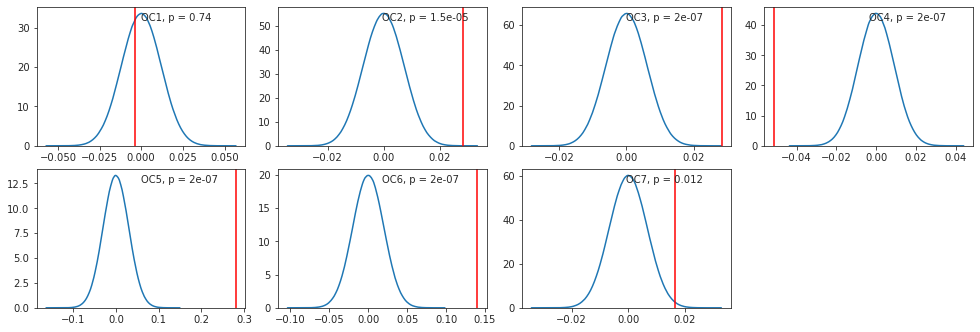

In [70]:
fig, axes = create_figure(2, 4, (13.5, 4.5), constrained_layout=True)
for i, p in enumerate(test.pvalue):
    ax = axes.flat[i]
    sns.kdeplot(test.null_distribution[:, i], ax=ax)
    ax.axvline(test.statistic[i], color='r')
    ax.annotate(
        text=f"OC{i+1}, p = {p:1.2g}",
        xycoords='axes fraction',
        xy=(0.5, 0.9),
        fontsize=10,
    )
    ax.set_ylabel('')
trim_axs(axes, len(test.pvalue))
plt.show()

In [72]:
multipletests(test.pvalue, method='bonferroni')

(
    array([False,  True,  True,  True,  True,  True, False]),
    array([1.00000000e+00, 1.04999990e-04, 1.39999986e-06, 1.39999986e-06,
       1.39999986e-06, 1.39999986e-06, 8.07323919e-02]),
    0.007300831979014655,
    0.0071428571428571435
)

### Do perm test at animal level

In [46]:
pi_anim = {}
for mode, o in results['bt_dict'].items():
    pi_anim[mode] = avg(o.run_pi, 2, 1)

In [47]:
sim_anim, sim_anim_overall = cosine_sim(pi_anim)
sim_anim = {
    k: v.diagonal(axis1=1, axis2=2)
    for k, v in sim_anim.items()
}

In [48]:
{k: v.shape for k, v in sim_anim.items()}

{
    ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'): (10, 7),
    ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'): (10, 7),
    ('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$'): (10, 7)
}

In [58]:
n_resamples = int(1e10)

def _statistic(a, b, axis=None):
    return np.nanmean(a - b, axis)

tests, tests_overall = {}, {}
looper = itertools.combinations(range(3), 2)
for i, (ii, jj) in enumerate(looper):
    # test sim
    cond_1, vals_1 = list(sim_anim.items())[ii]
    cond_2, vals_2 = list(sim_anim.items())[jj]
    tests[(cond_1, cond_2)] = sp_stats.permutation_test(
        data=(vals_1, vals_2),
        statistic=_statistic,
        n_resamples=n_resamples,
        permutation_type='samples',
        alternative='two-sided',
        vectorized=True,
        random_state=42,
        batch=5,
        axis=0,
    )
    # test sim overal
    cond_1, vals_1 = list(sim_anim_overall.items())[ii]
    cond_2, vals_2 = list(sim_anim_overall.items())[jj]
    tests_overall[(cond_1, cond_2)] = sp_stats.permutation_test(
        data=(vals_1, vals_2),
        statistic=_statistic,
        n_resamples=n_resamples,
        permutation_type='samples',
        alternative='two-sided',
        vectorized=False,
        random_state=42,
        batch=5,
    )

In [59]:
test = list(tests.values())[0]

In [60]:
test.statistic

array([ 0.05070282,  0.04910027,  0.02143212, -0.03017083,  0.29377377,
        0.19471777,  0.02373617])

In [61]:
test.pvalue

array([0.04882812, 0.00195312, 0.0234375 , 0.03125   , 0.00195312,
       0.00195312, 0.15820312])

## Prepare (128)

In [12]:
nn = 128
perc = 20
num_k = 7
mice = Mice(nn)

final_perm={4: 6, 5: 4, 6: 5}
final_perm = {
    i: final_perm.get(i, i)
    for i in range(num_k)
}

### Results

In [13]:
%%time

results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    merge_thres=0.376,
    n_resamples=int(1e4),
    final_perm=final_perm,
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 5min 33s, sys: 4.55 s, total: 5min 37s
Wall time: 5min 37s


[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'sim',
    'sim_overall',
    'sim_b',
    'sim_overall_b',
    'good_runs',
    'sim_run',
    'sim_run_overall',
    'tests',
    'tests_overall'
]

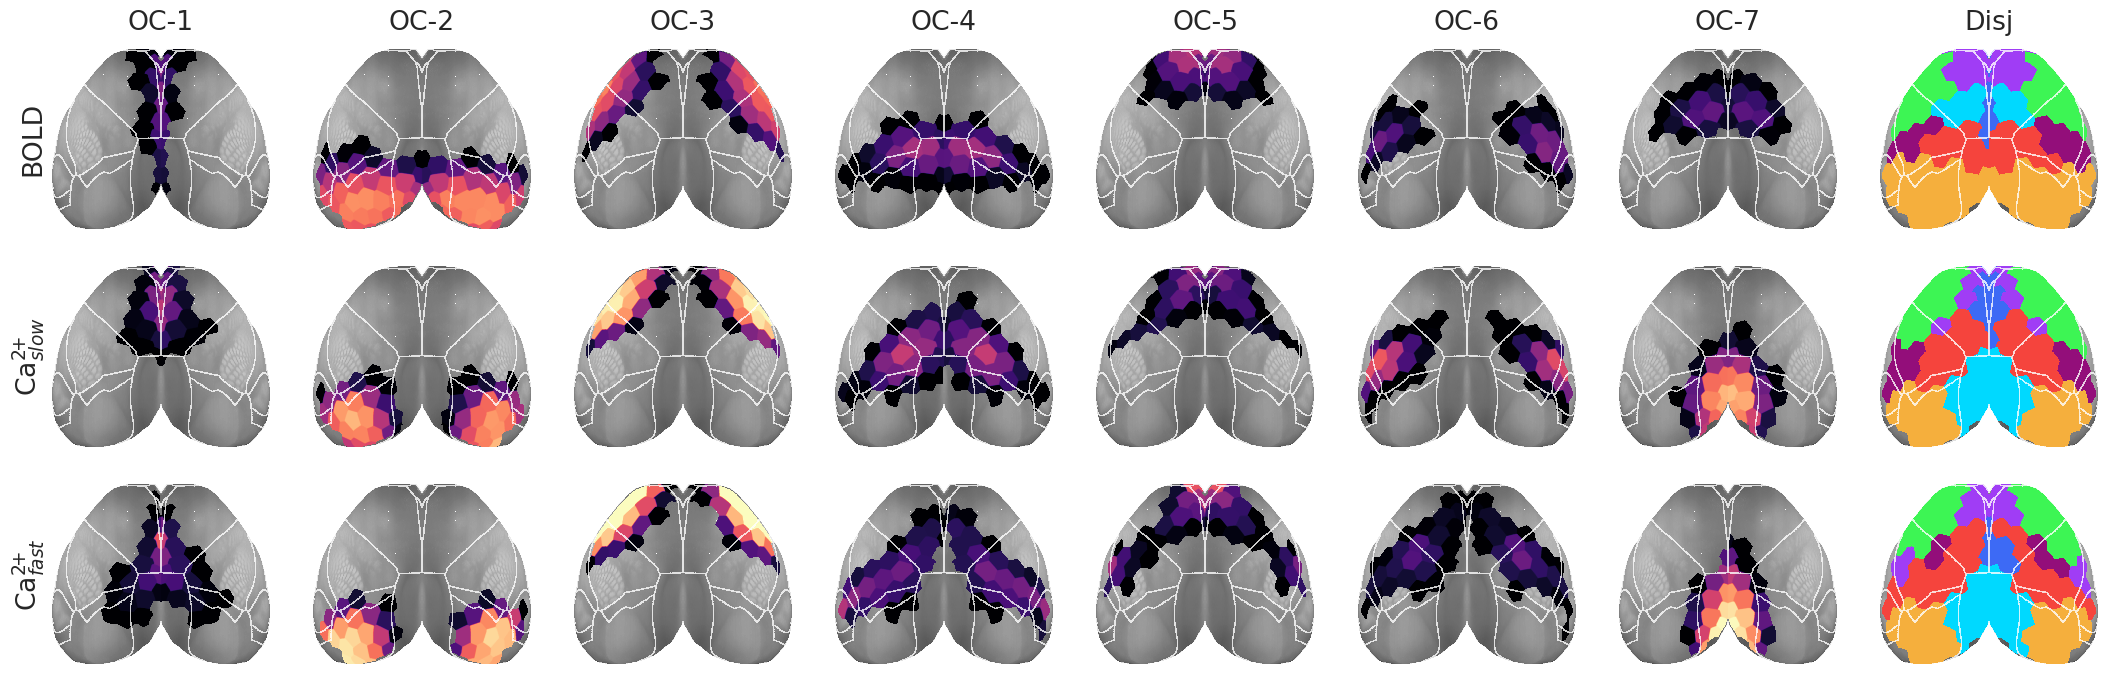

In [14]:
_ = bt.show(results['pi_sorted'], **show_kws(num_k))

### tests

#### Overall

In [15]:
test = list(results['tests_overall'].values())[0]

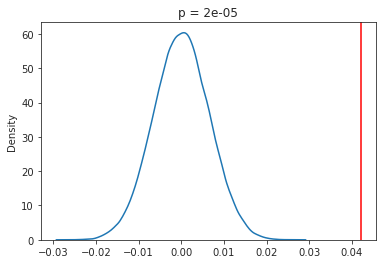

In [16]:
sns.kdeplot(test.null_distribution)
plt.axvline(test.statistic, color='r')
plt.title(f"p = {test.pvalue:1.2g}");

#### Diagonal terms

In [17]:
test = list(results['tests'].values())[0]

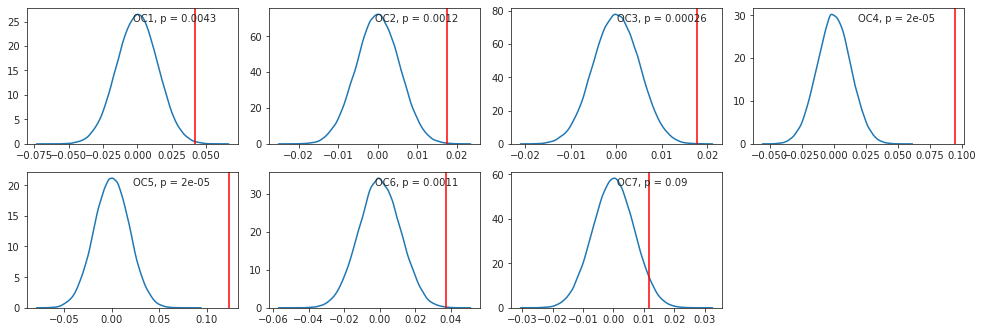

In [18]:
fig, axes = create_figure(2, 4, (13.5, 4.5), constrained_layout=True)
for i, p in enumerate(test.pvalue):
    ax = axes.flat[i]
    sns.kdeplot(test.null_distribution[:, i], ax=ax)
    ax.axvline(test.statistic[i], color='r')
    ax.annotate(
        text=f"OC{i+1}, p = {p:1.2g}",
        xycoords='axes fraction',
        xy=(0.5, 0.9),
        fontsize=10,
    )
    ax.set_ylabel('')
trim_axs(axes, len(test.pvalue))
plt.show()

In [19]:
multipletests(test.pvalue, method='bonferroni')

(
    array([ True,  True,  True,  True,  True,  True, False]),
    array([3.00996990e-02, 8.25991740e-03, 1.81998180e-03, 1.39998600e-04,
       1.39998600e-04, 7.41992580e-03, 6.33073669e-01]),
    0.007300831979014655,
    0.0071428571428571435
)